In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

# Data Preparation

In [95]:
df = pd.read_csv('dataset/cleandata_time_ok.csv', delimiter = ',')
print(df.shape)
display(df.head(2))
display(df.info())
display(df.describe())
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df.set_index('Date-Time', inplace = True)

(3491308, 12)


,Date-Time,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy
0,2021-01-04T09:30:01.673284287,Quote,NaN,NaN,19.0,24.0,19.07,6.0,NaN,2021-01-04,NaN,09:30:01.673284
1,2021-01-04T09:30:01.673284287,Quote,NaN,NaN,19.0,24.0,19.01,6.0,NaN,2021-01-04,NaN,09:30:01.673284


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3491308 entries, 0 to 3491307
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Date-Time           object 
 1   Type                object 
 2   Price               float64
 3   Volume              float64
 4   Bid Price           float64
 5   Bid Size            float64
 6   Ask Price           float64
 7   Ask Size            float64
 8   Tick Dir.           object 
 9   Date                object 
 10  num_tick_direction  float64
 11  Exchange_Time_copy  object 
dtypes: float64(7), object(5)
memory usage: 319.6+ MB


None

,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,num_tick_direction
count,1.377859e+06,1.377859e+06,3.491308e+06,3.491308e+06,3.491308e+06,3.491308e+06,377339.000000
mean,1.872580e+02,9.021554e+01,1.357627e+02,6.963457e+00,1.368762e+02,7.322325e+00,-0.000623
std,1.288883e+02,1.996205e+03,1.228293e+02,4.908565e+01,1.240740e+02,4.234311e+01,1.000001
min,1.710000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000
25%,6.625000e+01,5.000000e+00,3.891000e+01,1.000000e+00,3.903000e+01,1.000000e+00,-1.000000
50%,1.380100e+02,2.500000e+01,7.803000e+01,1.000000e+00,7.850000e+01,1.000000e+00,-1.000000
75%,3.188700e+02,1.000000e+02,2.593300e+02,3.000000e+00,2.630000e+02,3.000000e+00,1.000000
max,4.830000e+02,1.749449e+06,4.808600e+02,4.077000e+03,4.831700e+02,4.143000e+03,1.000000


## Trade Filter and To_Datetime

In [3]:
# Trade is for without resampling, to give insight on the overall period
trade = df[df['Type'] == 'Trade'].copy(deep = True)

# Trade_2 is the one for resampling 1-min and 5-min intervals
trade_2 = df[df['Type'] == 'Trade'].copy(deep = True)

# Trade_3 is for resampling 5-sec intervals
trade_3 = df[df['Type'] == 'Trade'].copy(deep = True)

display(trade.shape)
display(trade_2.shape)
display(trade_3.shape)

# Ensure date-time series
print(type(trade.index[0]))
print(type(trade_2.index[0]))
print(type(trade_3.index[0]))

(1377859, 11)

(1377859, 11)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [4]:
trade.info()
trade_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:59:59.984096412
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Type                1377859 non-null  object 
 1   Price               1377859 non-null  float64
 2   Volume              1377859 non-null  float64
 3   Bid Price           1377859 non-null  float64
 4   Bid Size            1377859 non-null  float64
 5   Ask Price           1377859 non-null  float64
 6   Ask Size            1377859 non-null  float64
 7   Tick Dir.           377339 non-null   object 
 8   Date                1377859 non-null  object 
 9   num_tick_direction  377339 non-null   float64
 10  Exchange_Time_copy  1377859 non-null  object 
dtypes: float64(7), object(4)
memory usage: 126.1+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:

## Global Charting

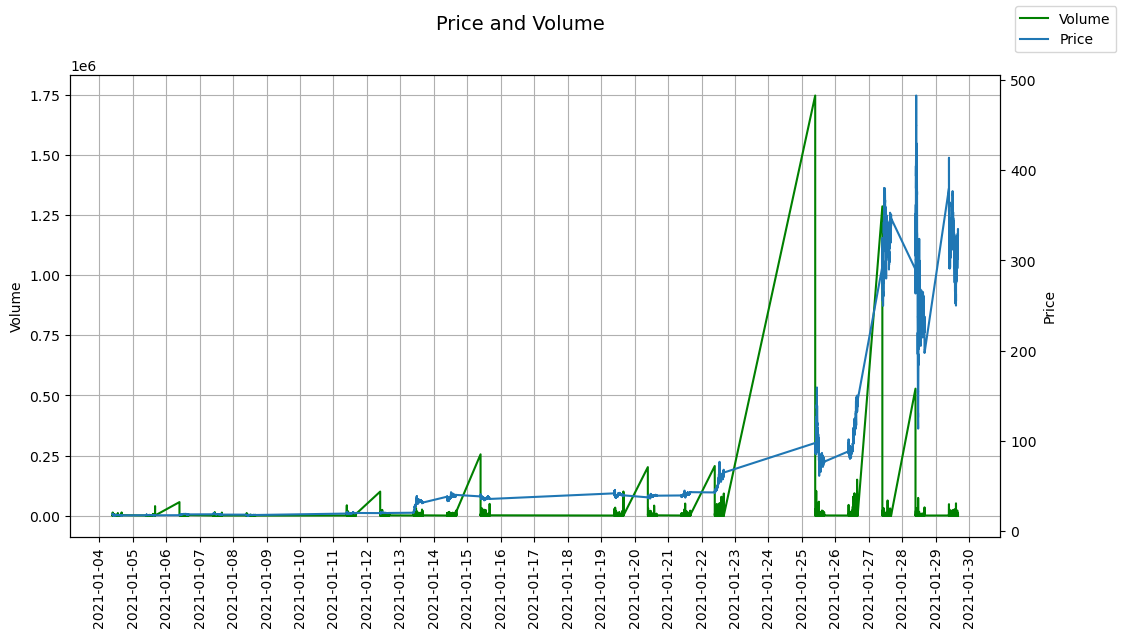

In [5]:
# Chart: Volume
fig = plt.figure(figsize = (12,6))
ax0 = fig.add_subplot(111)
ax0.plot(trade.index, trade['Volume'], 'g', label = 'Volume')
plt.xticks(rotation = 90)
ax0.grid()

# Chart: Price
ax1 = ax0.twinx()
ax1.plot(trade.index, trade['Price'], label = 'Price')

# Ticks, Title, Labels
ax0.xaxis.set_major_locator(mdates.DayLocator())
ax0.set_ylabel('Volume')
ax1.set_ylabel('Price')
fig.legend()
fig.suptitle('Price and Volume', fontsize = 14)

plt.show()


# Functions and Entire Dataset

## Helper Functions

In [135]:
def trade_cat(df):
    
    '''
    This is my interpretation of the result,
    modified by introducing Micro group and combining the Small subgroups, and Medium subgroups.
    '''
    
    # Trade Categories based on Literature

    # Calculate Volume Classifier L1
    df.loc[(df['Volume'] <= 199), 'Trade_Size_L1'] = 'Micro'
    df.loc[(df['Volume'] > 199) & (df['Volume'] <= 499), 'Trade_Size_L1'] = 'Small'
    df.loc[(df['Volume'] > 499) & (df['Volume'] <= 9999), 'Trade_Size_L1'] = 'Medium'
    df.loc[(df['Volume'] > 9999), 'Trade_Size_L1'] = 'Large'

    # Calculate Volume Classifier L2
    df.loc[df['Volume'] <= 199, 'Trade_Size_L2'] = '<200'
    df.loc[(df['Volume'] > 199 ) & (df['Volume'] <= 299), 'Trade_Size_L2'] = '200-299'
    df.loc[(df['Volume'] > 299 ) & (df['Volume'] <= 399), 'Trade_Size_L2'] = '300-399'
    df.loc[(df['Volume'] > 399 ) & (df['Volume'] <= 499), 'Trade_Size_L2'] = '400-499'
    df.loc[(df['Volume'] > 499) & (df['Volume'] <= 999), 'Trade_Size_L2'] = '500-999'
    df.loc[(df['Volume'] > 999) & (df['Volume'] <= 2999), 'Trade_Size_L2'] = '1000-2999'
    df.loc[(df['Volume'] > 2999) & (df['Volume'] <= 5999), 'Trade_Size_L2'] = '3000-5999'
    df.loc[(df['Volume'] > 5999) & (df['Volume'] <= 9999), 'Trade_Size_L2'] = '6000-9999'
    df.loc[(df['Volume'] > 9999), 'Trade_Size_L2'] = '10000+'
    
    return df

In [27]:
def mqr_prc_c(df):
    '''
    Calculate Mid-Quote Return and Cumulative Price Change
    '''
    # Mid Quote 
    df['Mid_Quote'] = (df['Bid Price'] + df['Ask Price'])/2
    
    # Add new column of previous mid-quote
    df['Prev_Mid_Quote'] = df['Mid_Quote'].shift(periods = 1).fillna(0)
    
    # Add new column of next mid-quote
    df['Next_Mid_Quote'] = df['Mid_Quote'].shift(periods = -1).fillna(0)
    
    # Mid Quote Return
    df['Mid_Quote_Return'] = ((df['Mid_Quote'] - df['Prev_Mid_Quote'])/df['Prev_Mid_Quote']).fillna(0)
    #replace inf and -inf with zero
    df.replace([np.inf, -np.inf], 0, inplace = True)

    # Add new column of previous price
    df['Prev_Price'] = df['Price'].shift(periods = 1).fillna(0)
    
    # Price Change
    df['Price_Change'] = (df['Price'] - df['Prev_Price']).fillna(0)
    df.loc[(df.index == min(df.index)), 'Price_Change'] = 0 # --> 1st row price change is always 0
    
    # Price Change -- Abs Value for Cross-Section Weighting
    df['Price_Change_Abs'] = np.abs(df['Price_Change'])
    
    
    # Reindex for a better look
    columns_re = ['Date','Exchange_Time_copy','Tick Dir.','num_tick_direction','Type', 'Volume', 'Trade_Size_L1', 'Trade_Size_L2', 'Bid Price', 'Bid Size',
              'Ask Price', 'Ask Size', 'Price', 'Prev_Price','Mid_Quote','Mid_Quote_Return',
               'Prev_Mid_Quote','Next_Mid_Quote','Price_Change','Price_Change_Abs']

    df = df.reindex(columns = columns_re)
    
    return df
    

In [8]:
def piv_varrat(df):
    '''
    Create pivot table of variance ratio as per literature
    '''
    # Create Pivot Table

    piv_varrat = pd.pivot_table(df, index = [df.index.date, 'Trade_Size_L1'],
                                 values = ['Mid_Quote_Return'], 
                                  aggfunc = np.std, margins = False)

    # Calculate value of Variance
    piv_varrat = piv_varrat.rename(columns = {'Mid_Quote_Return':'STD of MQR'})


    piv_varrat['Variance'] = (piv_varrat['STD of MQR'] **2)

    
    return piv_varrat
    

In [9]:
def plot_(df, interval, aggr):
    '''
    Can use this in a loop to compare resampling techniques
    '''

    # Value Counts
    display(trade['Trade_Size_L1'].value_counts())
    display(trade['Trade_Size_L2'].value_counts())
    trade_size_l1 = trade['Trade_Size_L1'].unique()

    # Plotting
    fig, ax = plt.subplots(figsize = (12,6))

    ax0 = fig.add_subplot()
    ax0.grid()
    plt.xticks(rotation = 90)

    ax1 = ax0.twinx()
    
    ax0 = sns.lineplot(x = df.index, y = 'Mid_Quote_Return', data = df, hue = 'Trade_Size_L1') #label = 'Mid-Quote Return'
    sns.lineplot(x = df.index, y = 'Price_Change', data = df, hue = 'Trade_Size_L1', ax = ax1, linestyle = '--') #label = 'Price Change'

   
    # Ticks, Title, Labels
    ax0.xaxis.set_major_locator(mdates.DayLocator())
    ax0.set_ylabel('Mid-Quote Return')
    ax1.set_ylabel('Price Change')
 
    fig.suptitle(f'Mid-Quote Return and Price Change by Size {interval} with {aggr} Aggregation', fontsize = 14)
    
    plt.show()

In [10]:
def piv_cumprice(df):
    '''
    Create pivot table as per literature
    '''
    # Create Pivot Table

    piv_cumprice = pd.pivot_table(df, index = ['Trade_Size_L1', 'Trade_Size_L2'],
                                 values = ['Price_Change', 'Price','Volume'], 
                                  aggfunc = {'Price_Change':np.sum,'Price':'count','Volume': np.sum}, margins = False)

    # Calculate value of %age, account for heteroskedasticity --> cross-section weight
    
#     abs_price_change = sum(df['Price_Change_Abs'])
#     print(abs_price_change)
    
    piv_cumprice['% Price_Change'] = np.round((piv_cumprice['Price_Change']/piv_cumprice['Price_Change'].sum())*100, 2)
    piv_cumprice['% Trade'] = np.round((piv_cumprice['Price']/piv_cumprice['Price'].sum())*100, 2)
    piv_cumprice['% Volume'] = np.round((piv_cumprice['Volume']/piv_cumprice['Volume'].sum())*100, 2)

    piv_cumprice = piv_cumprice.rename(columns = {'Price':'# of Trade'})

    # Final Pivot Table with sum
    piv_cumprice = pd.pivot_table(piv_cumprice, index = ['Trade_Size_L1', 'Trade_Size_L2'], 
                                  aggfunc = 'sum', margins = 'all')


    

    # Sort index S-M-L
    piv_cumprice = piv_cumprice.sort_index(level = [0, 1], ascending = [False, True]) 
    
    new_order = ['Price_Change', '% Price_Change',
                 '# of Trade', '% Trade', 'Volume', '% Volume']

    piv_cumprice = piv_cumprice.reindex(columns = new_order)

    display(piv_cumprice)
    

In [207]:
def simple_pi_spread(df):
    '''
    Calculate simple price impact and spreads (proxies for liquidity)
    Must be resampled for 5S interval based on literature
    '''
    # 1. Simple Price Impact
    # create a new column 'TickSB' based on the condition of Ask and Bid Price to Price
    
       
    df.loc[(df['Price'] < df['Mid_Quote']), 'TickSB'] = -1 # Seller initiated
    df.loc[(df['Price'] > df['Mid_Quote']), 'TickSB'] = 1 # Buyer initiated
    
    # Tick Test
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Prev_Price'] > df['Price']), 'TickSB'] = -1 # Seller initiated
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Prev_Price'] < df['Price']), 'TickSB'] = 1 # Buyer initiated
    df.loc[(df['Price'] == df['Mid_Quote']) & (df['Price_Change'] == 0), 'TickSB'] = 0 # Zero uptick
    
    # Calculate PI
    df['Simple_PI'] = 2 * df['TickSB'] * (df['Next_Mid_Quote'] - df['Mid_Quote'])/df['Mid_Quote']
    
    # 2. Spread
    df['Eff_Spread'] = 2 * df['TickSB'] * (df['Price'] - df['Mid_Quote'])/df['Mid_Quote']
    df['Realised_Spread'] = df['Eff_Spread'] - df['Simple_PI']
    
    return df

In [12]:
# In the resampled dataframes, the max might not be captured because the aggregation function is 'last'

max(trade['Volume'])


1749449.0

## Trade Category

In [136]:
# Trade category

# result = [trade_min_last, trade_h_last, trade_min_mean, trade_h_mean]
# for i in result:
#         i = trade_cat(i)
        
trade_cat(trade)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,Prev_Price,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:01.676587591,Trade,19.01,25.0,19.0,24.0,19.02,1.0,NaN,2021-01-04,NaN,09:30:01.676587,Micro,<200,19.01,0.00,19.030,0.000000,0.00,0.00,0.00
2021-01-04 09:30:02.752529040,Trade,19.04,20.0,19.0,24.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:02.752529,Micro,<200,19.03,19.01,19.030,0.001052,19.01,0.03,0.03
2021-01-04 09:30:03.784980999,Trade,19.05,2.0,19.0,24.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:03.784980,Micro,<200,19.03,19.03,19.030,0.000000,19.04,0.01,0.01
2021-01-04 09:30:04.792279959,Trade,19.05,49.0,19.0,22.0,19.06,1.0,NaN,2021-01-04,NaN,09:30:04.792279,Micro,<200,19.03,19.03,19.030,0.000000,19.05,0.00,0.00
2021-01-04 09:30:04.792279959,Trade,19.06,100.0,19.0,22.0,19.06,1.0,^,2021-01-04,1.0,09:30:04.792279,Micro,<200,19.03,19.03,19.055,0.000000,19.05,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:59.875667000,Trade,328.00,15.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.875667,Micro,<200,328.24,328.24,328.240,0.000000,328.00,0.00,0.00
2021-01-29 15:59:59.887567967,Trade,328.00,10.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.887567,Micro,<200,328.24,328.24,328.240,0.000000,328.00,0.00,0.00
2021-01-29 15:59:59.936339122,Trade,328.00,1.0,328.0,23.0,328.48,1.0,NaN,2021-01-29,NaN,15:59:59.936339,Micro,<200,328.24,328.24,328.240,0.000000,328.00,0.00,0.00


In [137]:
# Checking unique values of L1, should include Micro

trade['Trade_Size_L1'].unique()

array(['Micro', 'Small', 'Medium', 'Large'], dtype=object)

## Mid Quote Return

In [138]:
# Mid-Quote Return and Price Cumulative

# for i in result:
#         i = mqr_prc_c(i)

for_test = mqr_prc_c(trade)

# Testing for the final columns
for_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1377859 entries, 2021-01-04 09:30:01.676587591 to 2021-01-29 15:59:59.984096412
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Date                1377859 non-null  object 
 1   Exchange_Time_copy  1377859 non-null  object 
 2   Tick Dir.           377339 non-null   object 
 3   num_tick_direction  377339 non-null   float64
 4   Type                1377859 non-null  object 
 5   Volume              1377859 non-null  float64
 6   Trade_Size_L1       1377859 non-null  object 
 7   Trade_Size_L2       1377859 non-null  object 
 8   Bid Price           1377859 non-null  float64
 9   Bid Size            1377859 non-null  float64
 10  Ask Price           1377859 non-null  float64
 11  Ask Size            1377859 non-null  float64
 12  Price               1377859 non-null  float64
 13  Prev_Price          1377859 non-null  float64
 14  Mid_Quote    

In [139]:
# Test Formula to compare with the literature review
display(for_test.head(5))
mq_now = for_test.iloc[1,14]
mq_prev = for_test.iloc[0,14]
mqr = (mq_now - mq_prev)/mq_prev
print(mqr)
print(mqr == for_test.iloc[1,15]) 

,Date,Exchange_Time_copy,Tick Dir.,num_tick_direction,Type,Volume,Trade_Size_L1,Trade_Size_L2,Bid Price,Bid Size,Ask Price,Ask Size,Price,Prev_Price,Mid_Quote,Mid_Quote_Return,Prev_Mid_Quote,Next_Mid_Quote,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:01.676587591,2021-01-04,09:30:01.676587,NaN,NaN,Trade,25.0,Micro,<200,19.0,24.0,19.02,1.0,19.01,0.00,19.01,0.000000,0.00,19.030,0.00,0.00
2021-01-04 09:30:02.752529040,2021-01-04,09:30:02.752529,NaN,NaN,Trade,20.0,Micro,<200,19.0,24.0,19.06,1.0,19.04,19.01,19.03,0.001052,19.01,19.030,0.03,0.03
2021-01-04 09:30:03.784980999,2021-01-04,09:30:03.784980,NaN,NaN,Trade,2.0,Micro,<200,19.0,24.0,19.06,1.0,19.05,19.04,19.03,0.000000,19.03,19.030,0.01,0.01
2021-01-04 09:30:04.792279959,2021-01-04,09:30:04.792279,NaN,NaN,Trade,49.0,Micro,<200,19.0,22.0,19.06,1.0,19.05,19.05,19.03,0.000000,19.03,19.030,0.00,0.00
2021-01-04 09:30:04.792279959,2021-01-04,09:30:04.792279,^,1.0,Trade,100.0,Micro,<200,19.0,22.0,19.06,1.0,19.06,19.05,19.03,0.000000,19.03,19.055,0.01,0.01


0.0010520778537613429
True


In [30]:
# Test to see if the price change is indeed driven by Micro and Large

for_test.sort_values('Price_Change', ascending = False)

,Date,Exchange_Time_copy,Tick Dir.,num_tick_direction,Type,Volume,Trade_Size_L1,Trade_Size_L2,Bid Price,Bid Size,Ask Price,Ask Size,Price,Prev_Price,Mid_Quote,Mid_Quote_Return,Prev_Mid_Quote,Next_Mid_Quote,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-29 09:30:11.790758682,2021-01-29,09:30:11.790758,NaN,NaN,Trade,4.0,Micro,<100,379.97,1.0,380.00,6.0,380.00,197.44,379.985,0.926023,197.290,379.985,182.56,182.56
2021-01-27 09:43:51.232058291,2021-01-27,09:43:51.232058,^,1.0,Trade,1287888.0,Large,10000+,275.00,0.0,300.00,0.0,293.00,145.00,287.500,0.975945,145.500,287.500,148.00,148.00
2021-01-25 09:33:45.432156470,2021-01-25,09:33:45.432156,^,1.0,Trade,1749449.0,Large,10000+,96.00,0.0,99.00,0.0,97.56,64.75,97.500,0.502774,64.880,97.500,32.81,32.81
2021-01-28 13:20:44.988407649,2021-01-28,13:20:44.988407,NaN,NaN,Trade,1.0,Micro,<100,215.62,1.0,234.91,2.0,232.53,216.00,225.265,0.001378,224.955,225.265,16.53,16.53
2021-01-28 11:35:49.634958200,2021-01-28,11:35:49.634958,NaN,NaN,Trade,1.0,Micro,<100,169.00,1.0,169.98,5.0,169.97,155.10,169.490,0.092744,155.105,169.490,14.87,14.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-28 11:07:19.775866161,2021-01-28,11:07:19.775866,NaN,NaN,Trade,30.0,Micro,<100,226.00,19.0,227.00,1.0,226.20,237.86,226.500,-0.047659,237.835,226.500,-11.66,11.66
2021-01-28 13:20:45.076043384,2021-01-28,13:20:45.076043,NaN,NaN,Trade,25.0,Micro,<100,216.01,2.0,234.91,2.0,219.68,232.53,225.460,0.000000,225.460,226.000,-12.85,12.85
2021-01-28 11:19:10.016220303,2021-01-28,11:19:10.016220,NaN,NaN,Trade,2.0,Micro,<100,140.01,3.0,140.13,1.0,140.13,153.00,140.070,-0.084330,152.970,140.070,-12.87,12.87


In [31]:
# Similar test like above but for absolute values

for_test.sort_values('Price_Change_Abs', ascending = False)

,Date,Exchange_Time_copy,Tick Dir.,num_tick_direction,Type,Volume,Trade_Size_L1,Trade_Size_L2,Bid Price,Bid Size,Ask Price,Ask Size,Price,Prev_Price,Mid_Quote,Mid_Quote_Return,Prev_Mid_Quote,Next_Mid_Quote,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-29 09:30:11.790758682,2021-01-29,09:30:11.790758,NaN,NaN,Trade,4.0,Micro,<100,379.97,1.0,380.00,6.0,380.000,197.440,379.985,0.926023,197.29,379.985,182.56,182.56
2021-01-27 09:43:51.232058291,2021-01-27,09:43:51.232058,^,1.0,Trade,1287888.0,Large,10000+,275.00,0.0,300.00,0.0,293.000,145.000,287.500,0.975945,145.50,287.500,148.00,148.00
2021-01-28 09:30:28.291493819,2021-01-28,09:30:28.291493,v,-1.0,Trade,528491.0,Large,10000+,345.00,2.0,346.82,6.0,289.990,346.840,345.910,-0.000029,345.92,345.910,-56.85,56.85
2021-01-25 09:33:45.432156470,2021-01-25,09:33:45.432156,^,1.0,Trade,1749449.0,Large,10000+,96.00,0.0,99.00,0.0,97.560,64.750,97.500,0.502774,64.88,97.500,32.81,32.81
2021-01-28 11:13:31.751829366,2021-01-28,11:13:31.751829,NaN,NaN,Trade,1.0,Micro,<100,170.00,21.0,175.00,10.0,175.000,196.050,172.500,-0.120033,196.03,172.500,-21.05,21.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26 12:59:50.888255770,2021-01-26,12:59:50.888255,v,-1.0,Trade,100.0,Small,100-199,104.02,1.0,104.36,2.0,104.155,104.155,104.190,0.000000,104.19,104.190,0.00,0.00
2021-01-26 12:59:51.732561954,2021-01-26,12:59:51.732561,NaN,NaN,Trade,20.0,Micro,<100,104.00,1.0,104.36,2.0,104.040,104.040,104.180,-0.000096,104.19,104.180,0.00,0.00
2021-01-26 12:59:51.735553861,2021-01-26,12:59:51.735553,v,-1.0,Trade,531.0,Medium,500-999,104.00,1.0,104.36,2.0,104.000,104.000,104.180,0.000000,104.18,104.100,0.00,0.00


## Pivot Table

In [140]:
# Pivot

# for i in result:
#     piv_cumprice(i)

piv_cumprice(trade)

Price_Change  % Price_Change  # of Trade  \
Trade_Size_L1 Trade_Size_L2                                             
Small         200-299             -80.822          -26.16       55447   
              300-399             -14.720           -4.76       24195   
              400-499             -34.432          -11.14       12974   
Micro         <200                339.952          110.02     1251069   
Medium        1000-2999           -13.405           -4.34        9761   
              3000-5999             2.904            0.94        1571   
              500-999             -21.077           -6.82       22078   
              6000-9999             6.050            1.96         426   
Large         10000+              124.540           40.31         338   
All                               308.990          100.01     1377859   

                             % Trade       Volume  % Volume  
Trade_Size_L1 Trade_Size_L2                                  
Small         200-299           4.02   12008567.0      9.66  
              300-399           1.76    7741896.0      6.23  
              400-499           0.94    5487387.0      4.41  
Micro         <200             90.80   48726265.0     39.20  
Medium        1000-2999         0.71   15007505.0     12.07  
              3000-5999         0.11    6393466.0      5.14  
              500-999           1.60   14319734.0     11.52  
              6000-9999         0.03    3263107.0      2.63  
Large         10000+            0.02   11356370.0      9.14  
All                            99.99  124304297.0    100.00

# Event Studies

In [ ]:
# Make pivot table: pre-Reddit announcement, pre-Elon Musk, after

# 1-min and 5-min Dataframes

In [ ]:
# Flow: Split df into each day subdf, resample each subdf for 1H and 1min.
# Do SML Var Ratio
# Output Table:
'''
Date | L1 | Var 1min | Var 5min | Var Ratio

then plot for the entire period


'''

## Initial Descriptive

In [141]:
# Start Fresh with Trade 2

# Loop the df name
dates = np.unique(trade_2.index.day)

# A. 1-min INTERVAL
# ================
dfname_list_1min = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_1min.append(dfname)
print(dfname_list_1min)

# Resample each date's df
           
for i in range(len(dfname_list_1min)):
    
    df = trade_2[trade_2.index.day == dates[i]]
    
    dfname_list_1min[i] = df.resample('T').last().interpolate(method = 'linear')

# Concatenate

trade_1_min = pd.DataFrame()

for i in range(len(dfname_list_1min)):
    trade_1_min = pd.concat([trade_1_min, dfname_list_1min[i]])

display(trade_1_min)
print(trade_1_min.shape)

# B. 5-min INTERVAL
# ================

dfname_list_5min = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_5min.append(dfname)
print(dfname_list_5min)

# Resample each date's df
           
for i in range(len(dfname_list_5min)):
    
    df = trade_2[trade_2.index.day == dates[i]]
    
    dfname_list_5min[i] = df.resample('5T').last().interpolate(method = 'linear')

# Concatenate

trade_5_min = pd.DataFrame()

for i in range(len(dfname_list_5min)):
    trade_5_min = pd.concat([trade_5_min, dfname_list_5min[i]])

display(trade_5_min)
print(trade_5_min.shape)

['df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_19', 'df_20', 'df_21', 'df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy
Date-Time,,,,,,,,,,,
2021-01-04 09:30:00,Trade,19.03,53.0,19.00,17.0,19.05,1.0,v,2021-01-04,-1.0,09:30:51.273081
2021-01-04 09:31:00,Trade,18.98,55.0,18.95,1.0,19.02,2.0,v,2021-01-04,-1.0,09:31:56.932246
2021-01-04 09:32:00,Trade,18.96,85.0,18.92,1.0,18.97,1.0,^,2021-01-04,1.0,09:32:57.889233
2021-01-04 09:33:00,Trade,18.79,1050.0,18.79,10.0,18.84,2.0,v,2021-01-04,-1.0,09:33:49.305081
2021-01-04 09:34:00,Trade,18.66,20.0,18.65,9.0,18.71,3.0,v,2021-01-04,-1.0,09:34:51.448805
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:55:00,Trade,317.36,28.0,316.62,1.0,319.00,3.0,^,2021-01-29,1.0,15:55:59.675959
2021-01-29 15:56:00,Trade,321.00,1.0,320.95,2.0,321.99,2.0,^,2021-01-29,1.0,15:56:59.416251
2021-01-29 15:57:00,Trade,327.04,1.0,327.00,16.0,328.00,23.0,v,2021-01-29,-1.0,15:57:59.987839


(7394, 11)
['df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_19', 'df_20', 'df_21', 'df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy
Date-Time,,,,,,,,,,,
2021-01-04 09:30:00,Trade,18.66,20.0,18.65,9.0,18.71,3.0,v,2021-01-04,-1.0,09:34:51.448805
2021-01-04 09:35:00,Trade,18.20,157.0,18.18,7.0,18.26,1.0,v,2021-01-04,-1.0,09:39:52.040686
2021-01-04 09:40:00,Trade,18.16,50.0,18.09,1.0,18.21,1.0,^,2021-01-04,1.0,09:44:40.892317
2021-01-04 09:45:00,Trade,17.95,10.0,17.92,2.0,17.98,1.0,^,2021-01-04,1.0,09:49:57.901054
2021-01-04 09:50:00,Trade,17.57,47.0,17.56,6.0,17.60,1.0,^,2021-01-04,1.0,09:54:53.488966
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:35:00,Trade,312.01,10.0,311.07,1.0,314.99,2.0,v,2021-01-29,-1.0,15:39:59.416133
2021-01-29 15:40:00,Trade,319.23,30.0,318.53,1.0,319.90,4.0,^,2021-01-29,1.0,15:44:59.843839
2021-01-29 15:45:00,Trade,328.19,8.0,325.02,2.0,328.94,1.0,^,2021-01-29,1.0,15:49:59.880323


(1480, 11)


In [34]:
# Test to check NaN after resampling

nullval = trade_5_min['Price'].isna().sum()

print(nullval)

display(trade_5_min[trade_5_min['Price'].isna()]) # --> fine because not in the numbers

0


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy
Date-Time,,,,,,,,,,,


### Trade Category

In [142]:
display(trade_cat(trade_1_min))
display(trade_cat(trade_5_min))

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2
Date-Time,,,,,,,,,,,,,
2021-01-04 09:30:00,Trade,19.03,53.0,19.00,17.0,19.05,1.0,v,2021-01-04,-1.0,09:30:51.273081,Micro,<200
2021-01-04 09:31:00,Trade,18.98,55.0,18.95,1.0,19.02,2.0,v,2021-01-04,-1.0,09:31:56.932246,Micro,<200
2021-01-04 09:32:00,Trade,18.96,85.0,18.92,1.0,18.97,1.0,^,2021-01-04,1.0,09:32:57.889233,Micro,<200
2021-01-04 09:33:00,Trade,18.79,1050.0,18.79,10.0,18.84,2.0,v,2021-01-04,-1.0,09:33:49.305081,Medium,1000-2999
2021-01-04 09:34:00,Trade,18.66,20.0,18.65,9.0,18.71,3.0,v,2021-01-04,-1.0,09:34:51.448805,Micro,<200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:55:00,Trade,317.36,28.0,316.62,1.0,319.00,3.0,^,2021-01-29,1.0,15:55:59.675959,Micro,<200
2021-01-29 15:56:00,Trade,321.00,1.0,320.95,2.0,321.99,2.0,^,2021-01-29,1.0,15:56:59.416251,Micro,<200
2021-01-29 15:57:00,Trade,327.04,1.0,327.00,16.0,328.00,23.0,v,2021-01-29,-1.0,15:57:59.987839,Micro,<200


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2
Date-Time,,,,,,,,,,,,,
2021-01-04 09:30:00,Trade,18.66,20.0,18.65,9.0,18.71,3.0,v,2021-01-04,-1.0,09:34:51.448805,Micro,<200
2021-01-04 09:35:00,Trade,18.20,157.0,18.18,7.0,18.26,1.0,v,2021-01-04,-1.0,09:39:52.040686,Micro,<200
2021-01-04 09:40:00,Trade,18.16,50.0,18.09,1.0,18.21,1.0,^,2021-01-04,1.0,09:44:40.892317,Micro,<200
2021-01-04 09:45:00,Trade,17.95,10.0,17.92,2.0,17.98,1.0,^,2021-01-04,1.0,09:49:57.901054,Micro,<200
2021-01-04 09:50:00,Trade,17.57,47.0,17.56,6.0,17.60,1.0,^,2021-01-04,1.0,09:54:53.488966,Micro,<200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:35:00,Trade,312.01,10.0,311.07,1.0,314.99,2.0,v,2021-01-29,-1.0,15:39:59.416133,Micro,<200
2021-01-29 15:40:00,Trade,319.23,30.0,318.53,1.0,319.90,4.0,^,2021-01-29,1.0,15:44:59.843839,Micro,<200
2021-01-29 15:45:00,Trade,328.19,8.0,325.02,2.0,328.94,1.0,^,2021-01-29,1.0,15:49:59.880323,Micro,<200


### Mid Quote Return

In [143]:
mqr_prc_c(trade_1_min)
mqr_prc_c(trade_5_min)

,Date,Exchange_Time_copy,Tick Dir.,num_tick_direction,Type,Volume,Trade_Size_L1,Trade_Size_L2,Bid Price,Bid Size,Ask Price,Ask Size,Price,Prev_Price,Mid_Quote,Mid_Quote_Return,Prev_Mid_Quote,Next_Mid_Quote,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:00,2021-01-04,09:34:51.448805,v,-1.0,Trade,20.0,Micro,<200,18.65,9.0,18.71,3.0,18.66,0.00,18.680,0.000000,0.000,18.220,0.00,0.00
2021-01-04 09:35:00,2021-01-04,09:39:52.040686,v,-1.0,Trade,157.0,Micro,<200,18.18,7.0,18.26,1.0,18.20,18.66,18.220,-0.024625,18.680,18.150,-0.46,0.46
2021-01-04 09:40:00,2021-01-04,09:44:40.892317,^,1.0,Trade,50.0,Micro,<200,18.09,1.0,18.21,1.0,18.16,18.20,18.150,-0.003842,18.220,17.950,-0.04,0.04
2021-01-04 09:45:00,2021-01-04,09:49:57.901054,^,1.0,Trade,10.0,Micro,<200,17.92,2.0,17.98,1.0,17.95,18.16,17.950,-0.011019,18.150,17.580,-0.21,0.21
2021-01-04 09:50:00,2021-01-04,09:54:53.488966,^,1.0,Trade,47.0,Micro,<200,17.56,6.0,17.60,1.0,17.57,17.95,17.580,-0.020613,17.950,17.430,-0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:35:00,2021-01-29,15:39:59.416133,v,-1.0,Trade,10.0,Micro,<200,311.07,1.0,314.99,2.0,312.01,313.00,313.030,0.000096,313.000,319.215,-0.99,0.99
2021-01-29 15:40:00,2021-01-29,15:44:59.843839,^,1.0,Trade,30.0,Micro,<200,318.53,1.0,319.90,4.0,319.23,312.01,319.215,0.019758,313.030,326.980,7.22,7.22
2021-01-29 15:45:00,2021-01-29,15:49:59.880323,^,1.0,Trade,8.0,Micro,<200,325.02,2.0,328.94,1.0,328.19,319.23,326.980,0.024325,319.215,325.395,8.96,8.96


### Plot and Bins

Micro     1251069
Small       92616
Medium      33836
Large         338
Name: Trade_Size_L1, dtype: int64

<200         1251069
200-299        55447
300-399        24195
500-999        22078
400-499        12974
1000-2999       9761
3000-5999       1571
6000-9999        426
10000+           338
Name: Trade_Size_L2, dtype: int64

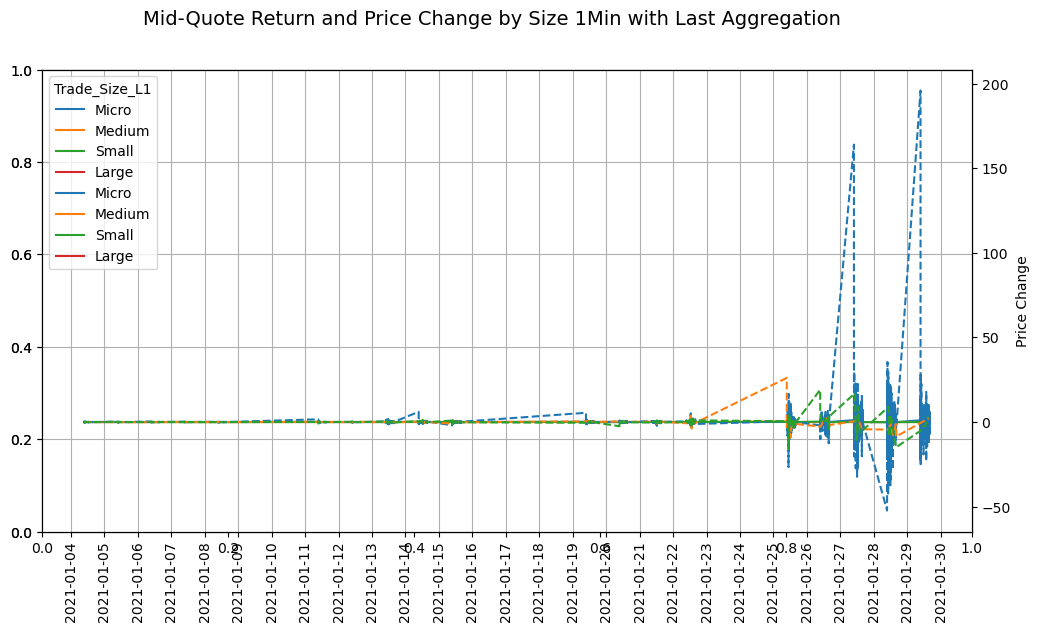

Micro     1251069
Small       92616
Medium      33836
Large         338
Name: Trade_Size_L1, dtype: int64

<200         1251069
200-299        55447
300-399        24195
500-999        22078
400-499        12974
1000-2999       9761
3000-5999       1571
6000-9999        426
10000+           338
Name: Trade_Size_L2, dtype: int64

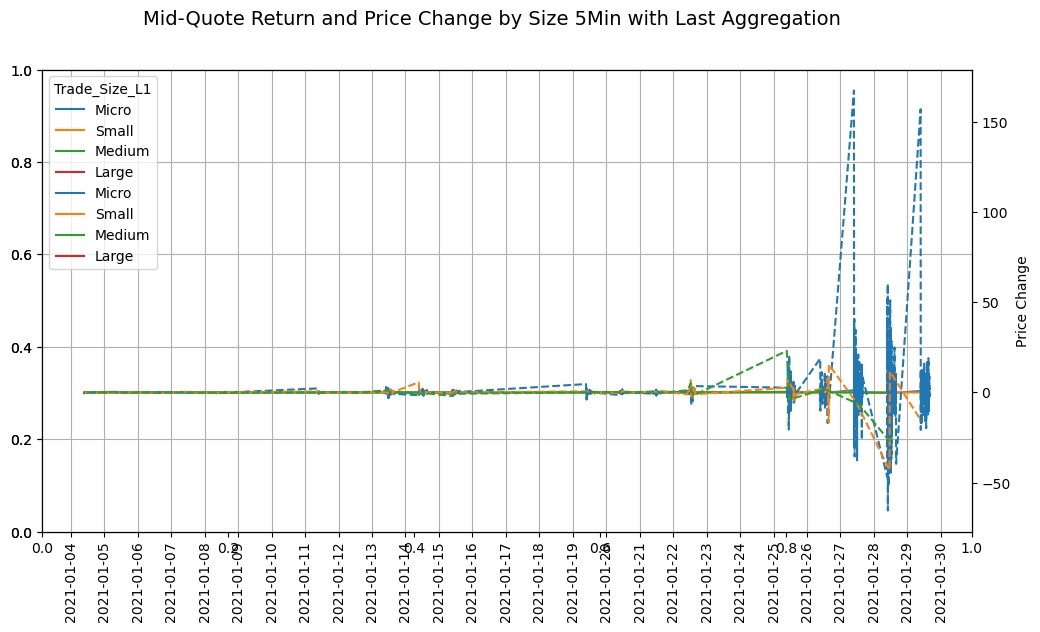

In [144]:
plot_(trade_1_min, '1Min', 'Last')
plot_(trade_5_min, '5Min', 'Last')

### Pivot Table

In [145]:
piv_cumprice(trade_1_min)
piv_cumprice(trade_5_min)

Price_Change  % Price_Change  # of Trade  \
Trade_Size_L1 Trade_Size_L2                                             
Small         200-299             57.5720           18.63         591   
              300-399             -7.4540           -2.41         205   
              400-499            -11.6895           -3.78          89   
Micro         <200               305.5315           98.89        6266   
Medium        1000-2999          -19.9770           -6.47          56   
              3000-5999          -12.3570           -4.00           7   
              500-999             -3.5160           -1.14         177   
              6000-9999            0.8900            0.29           2   
Large         10000+              -0.0300           -0.01           1   
All                              308.9700          100.00        7394   

                             % Trade         Volume  % Volume  
Trade_Size_L1 Trade_Size_L2                                    
Small         200-299           7.99  123663.866667     14.36  
              300-399           2.77   64509.533333      7.49  
              400-499           1.20   37025.600000      4.30  
Micro         <200             84.74  376281.900000     43.70  
Medium        1000-2999         0.76   82759.000000      9.61  
              3000-5999         0.09   32365.200000      3.76  
              500-999           2.39  112562.400000     13.07  
              6000-9999         0.03   16852.000000      1.96  
Large         10000+            0.01   15000.000000      1.74  
All                            99.98  861019.500000     99.99

Price_Change  % Price_Change  # of Trade  \
Trade_Size_L1 Trade_Size_L2                                             
Small         200-299              40.775           13.18         118   
              300-399             -40.931          -13.23          40   
              400-499               5.630            1.82          22   
Micro         <200                311.165          100.59        1256   
Medium        1000-2999             3.250            1.05          12   
              3000-5999           -26.860           -8.68           2   
              500-999              15.971            5.16          29   
Large         10000+                0.340            0.11           1   
All                               309.340          100.00        1480   

                             % Trade    Volume  % Volume  
Trade_Size_L1 Trade_Size_L2                               
Small         200-299           7.97   24827.5     13.37  
              300-399           2.70   12401.0      6.68  
              400-499           1.49    9325.0      5.02  
Micro         <200             84.86   75179.0     40.48  
Medium        1000-2999         0.81   19145.0     10.31  
              3000-5999         0.14   10600.0      5.71  
              500-999           1.96   19232.0     10.36  
Large         10000+            0.07   15000.0      8.08  
All                           100.00  185709.5    100.01

## Variance Ratio

### Var Ratio

In [146]:
trade_5_min[trade_5_min['Trade_Size_L1'] == 'Large'] #--> that's why no data on pivot because only 1, cannot calc STD

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,Prev_Price,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-14 15:55:00,Trade,39.95,15000.0,39.91,13.0,39.95,107.0,^,2021-01-14,1.0,15:59:59.560242,Large,10000+,39.93,39.615,39.135,0.007952,39.61,0.34,0.34


In [147]:
# Checking unique values because if there's only 1 entry, cannot calculate std - var

print('Trade_1_min unique value counts:\n', trade_1_min['Trade_Size_L1'].value_counts())
print('Trade_5_min unique value counts:\n', trade_5_min['Trade_Size_L1'].value_counts())

#--> from the result, exclude 'Large' from the variance ratio calc

Trade_1_min unique value counts:
 Micro     6266
Small      885
Medium     242
Large        1
Name: Trade_Size_L1, dtype: int64
Trade_5_min unique value counts:
 Micro     1256
Small      180
Medium      43
Large        1
Name: Trade_Size_L1, dtype: int64


In [148]:
# Assigning variable names for variance ratio study

# Trade_1_min

trade_1_min_varrat_df = []
trade_5_min_varrat_df = []

for i in ['Micro','Small', 'Medium']:
    trade_1_min_varrat = piv_varrat(trade_1_min[trade_1_min['Trade_Size_L1'] == i])
    trade_1_min_varrat_df.append(trade_1_min_varrat)
    
    trade_5_min_varrat = piv_varrat(trade_5_min[trade_5_min['Trade_Size_L1'] == i])
    trade_5_min_varrat_df.append(trade_5_min_varrat)
    
# Test
display(trade_1_min_varrat_df[0])
display(trade_5_min_varrat_df[2])


,,STD of MQR,Variance
,Trade_Size_L1,,
2021-01-04,Micro,0.002828,0.000008
2021-01-05,Micro,0.002064,0.000004
2021-01-06,Micro,0.002722,0.000007
2021-01-07,Micro,0.002073,0.000004
2021-01-08,Micro,0.002335,0.000005
2021-01-11,Micro,0.006585,0.000043
2021-01-12,Micro,0.002188,0.000005
2021-01-13,Micro,0.012111,0.000147
2021-01-14,Micro,0.013415,0.000180


,,STD of MQR,Variance
,Trade_Size_L1,,
2021-01-04,Medium,0.004490,2.016280e-05
2021-01-05,Medium,0.019660,3.865200e-04
2021-01-06,Medium,0.001152,1.327480e-06
2021-01-07,Medium,0.006172,3.809395e-05
2021-01-11,Medium,0.005218,2.723043e-05
2021-01-13,Medium,0.015733,2.475395e-04
2021-01-14,Medium,0.005799,3.362848e-05
2021-01-15,Medium,0.024015,5.767400e-04
2021-01-19,Medium,0.000728,5.298933e-07


In [149]:
# Inner Join based on Trade L1 -- different size different list

inner_join_df = []

for i in range(len(trade_1_min_varrat_df)): # --> contains 3 df of micro, small, medium
    index0_ = trade_1_min_varrat_df[i].index.names[0]
    index1_ = trade_1_min_varrat_df[i].index.names[1]
    
    # Inner Join and Rename Columns 
    in_join = pd.merge(trade_1_min_varrat_df[i], trade_5_min_varrat_df[i], on = [index0_, index1_], how = 'inner').rename(columns = {'STD of MQR_x':'STD of MQR_1', 
                                                                                                                                     'Variance_x':'Var_of_MQR_1',
                                               'STD of MQR_y':'STD of MQR_5', 'Variance_y':'Var_of_MQR_5'
                                               })
    
    # Variance Ratio calculation
    in_join['Var_Rat'] = np.abs((in_join['Var_of_MQR_5']/(5 * in_join['Var_of_MQR_1'])) - 1)
    
    inner_join_df.append(in_join)  

# Test
display(max(inner_join_df[0]['Var_Rat']), min(inner_join_df[0]['Var_Rat']))
display(max(inner_join_df[1]['Var_Rat']), min(inner_join_df[1]['Var_Rat']))
display(max(inner_join_df[2]['Var_Rat']), min(inner_join_df[2]['Var_Rat']))
display(inner_join_df[0])

# Twin axes because Medium Variance Ratio skews the observation

0.7785027607078814

0.010855801526091113

7.405264127220148

0.10123238599408513

8.211251593301622

0.06979604856009824

,key_0,STD of MQR_1,Var_of_MQR_1,STD of MQR_5,Var_of_MQR_5,Var_Rat
Trade_Size_L1,,,,,,
Micro,"(2021-01-04, Micro)",0.002828,0.000008,0.006284,0.000039,0.012049
Micro,"(2021-01-05, Micro)",0.002064,0.000004,0.003553,0.000013,0.407099
Micro,"(2021-01-06, Micro)",0.002722,0.000007,0.006119,0.000037,0.010856
Micro,"(2021-01-07, Micro)",0.002073,0.000004,0.004372,0.000019,0.110553
Micro,"(2021-01-08, Micro)",0.002335,0.000005,0.005386,0.000029,0.064210
Micro,"(2021-01-11, Micro)",0.006585,0.000043,0.019638,0.000386,0.778503
Micro,"(2021-01-12, Micro)",0.002188,0.000005,0.005900,0.000035,0.454408
Micro,"(2021-01-13, Micro)",0.012111,0.000147,0.035892,0.001288,0.756660
Micro,"(2021-01-14, Micro)",0.013415,0.000180,0.020656,0.000427,0.525805


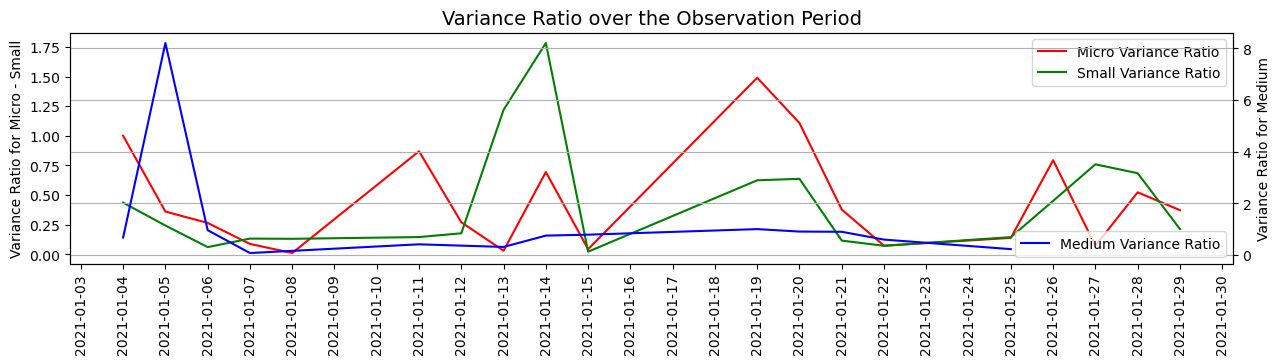

In [43]:
# Plotting the Variance Ratio among 3 trade sizes


# Index for plots Micro, Small, Medium

list_x_index = []

for i in inner_join_df:
    
    list_x = list(i['key_0'])
    index_date_ = []
    for j in list_x:
        date_a = j[0]
        index_date_.append(date_a)
    list_x_index.append(index_date_)

# print(list_x_index)

# Set x and y
index_mic = list_x_index[0]
index_s = list_x_index[1]
index_med = list_x_index[2]

var_rat_mic = inner_join_df[0]['Var_Rat']
var_rat_s = inner_join_df[1]['Var_Rat']
var_rat_med = inner_join_df[2]['Var_Rat']

# Plotting
fig, ax0 = plt.subplots(figsize = (15,3))
ax0.plot(index_mic, var_rat_mic, 'r-', label = 'Micro Variance Ratio')
ax0.plot(index_s, var_rat_s, 'g-', label = 'Small Variance Ratio')
plt.xticks(rotation = 90)

ax1 = ax0.twinx()
ax1.plot(index_med, var_rat_med, 'b-', label = 'Medium Variance Ratio')

ax0.legend(loc = 'upper right')
ax1.legend(loc = 'lower right')

# Ticks, Title, Labels
ax0.xaxis.set_major_locator(mdates.DayLocator())
ax0.set_ylabel('Variance Ratio for Micro - Small')
ax1.set_ylabel('Variance Ratio for Medium')

plt.grid()
plt.title('Variance Ratio over the Observation Period', fontsize = 14)
plt.show()


## Regression and Robustness Check

In [168]:
trade_1_min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7394 entries, 2021-01-04 09:30:00 to 2021-01-29 15:59:00
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                7144 non-null   object 
 1   Price               7394 non-null   float64
 2   Volume              7394 non-null   float64
 3   Bid Price           7394 non-null   float64
 4   Bid Size            7394 non-null   float64
 5   Ask Price           7394 non-null   float64
 6   Ask Size            7394 non-null   float64
 7   Tick Dir.           7037 non-null   object 
 8   Date                7144 non-null   object 
 9   num_tick_direction  7394 non-null   float64
 10  Exchange_Time_copy  7144 non-null   object 
 11  Trade_Size_L1       7394 non-null   object 
 12  Trade_Size_L2       7394 non-null   object 
 13  Mid_Quote           7394 non-null   float64
 14  Prev_Mid_Quote      7394 non-null   float64
 15  Next_Mid_Quote     

In [169]:
# One-hot Encoding

X_1 = trade_1_min[['Volume']] 
X_2 = pd.get_dummies(trade_1_min['Trade_Size_L1'])

print(f'X_1 shape: {X_1.shape}, X_1 columns = {X_1.columns}')
print(f'X_2 shape: {X_2.shape}, X_2 columns = {X_2.columns}')
y = trade_1_min['Price_Change']
print(f'y shape: {y.shape}')

X_1 shape: (7394, 1), X_1 columns = Index(['Volume'], dtype='object')
X_2 shape: (7394, 4), X_2 columns = Index(['Large', 'Medium', 'Micro', 'Small'], dtype='object')
y shape: (7394,)


In [170]:
display(X_2.head(5))

,Large,Medium,Micro,Small
Date-Time,,,,
2021-01-04 09:30:00,0,0,1,0
2021-01-04 09:31:00,0,0,1,0
2021-01-04 09:32:00,0,0,1,0
2021-01-04 09:33:00,0,1,0,0
2021-01-04 09:34:00,0,0,1,0


In [171]:
X = pd.concat([X_2, X_1], axis = 1)
display(X)

,Large,Medium,Micro,Small,Volume
Date-Time,,,,,
2021-01-04 09:30:00,0,0,1,0,53.0
2021-01-04 09:31:00,0,0,1,0,55.0
2021-01-04 09:32:00,0,0,1,0,85.0
2021-01-04 09:33:00,0,1,0,0,1050.0
2021-01-04 09:34:00,0,0,1,0,20.0
...,...,...,...,...,...
2021-01-29 15:55:00,0,0,1,0,28.0
2021-01-29 15:56:00,0,0,1,0,1.0
2021-01-29 15:57:00,0,0,1,0,1.0


In [172]:
# Reindex the columns so Micro will be the 1st column: Mic - S - M - L
X = X.reindex(columns = ['Micro', 'Small', 'Medium', 'Large', 'Volume'])
display(X)

,Micro,Small,Medium,Large,Volume
Date-Time,,,,,
2021-01-04 09:30:00,1,0,0,0,53.0
2021-01-04 09:31:00,1,0,0,0,55.0
2021-01-04 09:32:00,1,0,0,0,85.0
2021-01-04 09:33:00,0,0,1,0,1050.0
2021-01-04 09:34:00,1,0,0,0,20.0
...,...,...,...,...,...
2021-01-29 15:55:00,1,0,0,0,28.0
2021-01-29 15:56:00,1,0,0,0,1.0
2021-01-29 15:57:00,1,0,0,0,1.0


,Micro,Small,Medium,Large,Volume,Price_Change
Date-Time,,,,,,
2021-01-04 09:30:00,1,0,0,0,53.0,0.00
2021-01-04 09:31:00,1,0,0,0,55.0,-0.05
2021-01-04 09:32:00,1,0,0,0,85.0,-0.02
2021-01-04 09:33:00,0,0,1,0,1050.0,-0.17
2021-01-04 09:34:00,1,0,0,0,20.0,-0.13
...,...,...,...,...,...,...
2021-01-29 15:55:00,1,0,0,0,28.0,-8.38
2021-01-29 15:56:00,1,0,0,0,1.0,3.64
2021-01-29 15:57:00,1,0,0,0,1.0,6.04


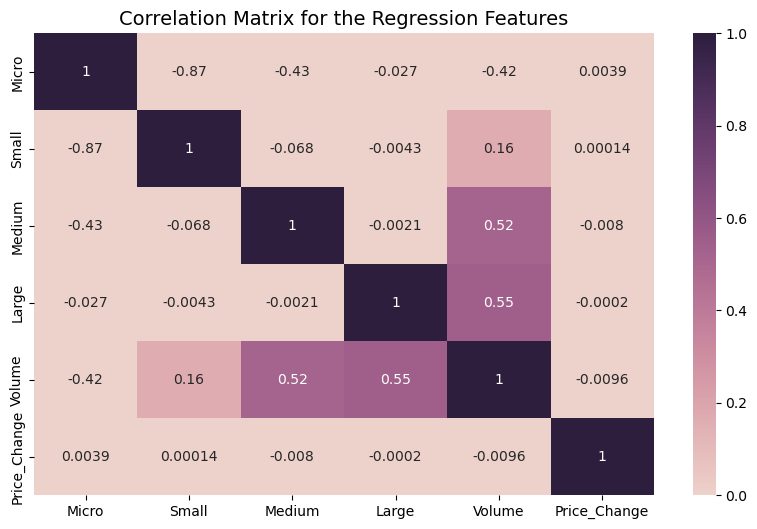

In [173]:
# Correlation Matrix

combined = pd.concat([X, y], axis = 1)
display(combined)
combined_corr = combined.corr()
plt.figure(figsize = (10,6))
sns.heatmap(combined_corr, vmin = 0., vmax = 1., cmap = sns.cubehelix_palette(as_cmap = True), annot = True)
plt.title('Correlation Matrix for the Regression Features', fontsize = 14)
plt.show()


In [174]:
# Linear Regression

X = sm.add_constant(X)
linreg = sm.OLS(y, X)
results = linreg.fit()
print(results.summary())
print(results.t_test)

                            OLS Regression Results                            
Dep. Variable:           Price_Change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2483
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.911
Time:                        23:56:49   Log-Likelihood:                -21216.
No. Observations:                7394   AIC:                         4.244e+04
Df Residuals:                    7389   BIC:                         4.248e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5755      1.189      0.484      0.6

# 5-sec Dataframe for Simple PI, Spread

For calculating simple price impact and spread, the data must be resampled in 5s interval as per literature.

## Resample 5-s

In [150]:
# Start Fresh with Trade 3

# Loop the df name
dates = np.unique(trade_3.index.day)

# A. 5-s INTERVAL
# ================
dfname_list_5s = []
for i in dates:
    dfname = 'df_' + str(i)
    dfname_list_5s.append(dfname)
print(dfname_list_5s)

# Resample each date's df
           
for i in range(len(dfname_list_5s)):
    
    df = trade_3[trade_3.index.day == dates[i]]
    
    dfname_list_5s[i] = df.resample('5S').last().interpolate(method = 'linear')

# Concatenate

trade_5_s = pd.DataFrame()

for i in range(len(dfname_list_5s)):
    trade_5_s = pd.concat([trade_5_s, dfname_list_5s[i]])

display(trade_5_s)
print(trade_5_s.shape)


['df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_19', 'df_20', 'df_21', 'df_22', 'df_25', 'df_26', 'df_27', 'df_28', 'df_29']


,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy
Date-Time,,,,,,,,,,,
2021-01-04 09:30:00,Trade,19.060000,100.0,19.000000,22.000000,19.060,1.0,^,2021-01-04,1.000000,09:30:04.792279
2021-01-04 09:30:05,Trade,19.100000,85.0,19.040000,2.000000,19.100,1.0,^,2021-01-04,1.000000,09:30:06.896485
2021-01-04 09:30:10,None,19.080000,92.5,19.020000,12.500000,19.095,1.0,None,None,1.000000,None
2021-01-04 09:30:15,Trade,19.060000,100.0,19.000000,23.000000,19.090,1.0,^,2021-01-04,1.000000,09:30:16.900475
2021-01-04 09:30:20,None,19.056667,100.0,19.003333,15.666667,19.080,1.0,None,None,0.333333,None
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,Trade,328.010000,17.0,328.000000,50.000000,328.470,1.0,v,2021-01-29,-1.000000,15:59:39.992096
2021-01-29 15:59:40,Trade,328.750000,70.0,328.470000,7.000000,328.940,1.0,v,2021-01-29,-1.000000,15:59:44.984080
2021-01-29 15:59:45,Trade,328.490000,1.0,328.490000,6.000000,328.500,2.0,^,2021-01-29,1.000000,15:59:49.976162


(88689, 11)


## Run All the Preceding Functions

In [151]:
display(trade_cat(trade_5_s))
display(mqr_prc_c(trade_5_s))

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,Exchange_Time_copy,Trade_Size_L1,Trade_Size_L2
Date-Time,,,,,,,,,,,,,
2021-01-04 09:30:00,Trade,19.060000,100.0,19.000000,22.000000,19.060,1.0,^,2021-01-04,1.000000,09:30:04.792279,Micro,<200
2021-01-04 09:30:05,Trade,19.100000,85.0,19.040000,2.000000,19.100,1.0,^,2021-01-04,1.000000,09:30:06.896485,Micro,<200
2021-01-04 09:30:10,None,19.080000,92.5,19.020000,12.500000,19.095,1.0,None,None,1.000000,None,Micro,<200
2021-01-04 09:30:15,Trade,19.060000,100.0,19.000000,23.000000,19.090,1.0,^,2021-01-04,1.000000,09:30:16.900475,Micro,<200
2021-01-04 09:30:20,None,19.056667,100.0,19.003333,15.666667,19.080,1.0,None,None,0.333333,None,Micro,<200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,Trade,328.010000,17.0,328.000000,50.000000,328.470,1.0,v,2021-01-29,-1.000000,15:59:39.992096,Micro,<200
2021-01-29 15:59:40,Trade,328.750000,70.0,328.470000,7.000000,328.940,1.0,v,2021-01-29,-1.000000,15:59:44.984080,Micro,<200
2021-01-29 15:59:45,Trade,328.490000,1.0,328.490000,6.000000,328.500,2.0,^,2021-01-29,1.000000,15:59:49.976162,Micro,<200


,Date,Exchange_Time_copy,Tick Dir.,num_tick_direction,Type,Volume,Trade_Size_L1,Trade_Size_L2,Bid Price,Bid Size,Ask Price,Ask Size,Price,Prev_Price,Mid_Quote,Mid_Quote_Return,Prev_Mid_Quote,Next_Mid_Quote,Price_Change,Price_Change_Abs
Date-Time,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:00,2021-01-04,09:30:04.792279,^,1.000000,Trade,100.0,Micro,<200,19.000000,22.000000,19.060,1.0,19.060000,0.00,19.030000,0.000000,0.0000,19.070000,0.000000,0.000000
2021-01-04 09:30:05,2021-01-04,09:30:06.896485,^,1.000000,Trade,85.0,Micro,<200,19.040000,2.000000,19.100,1.0,19.100000,19.06,19.070000,0.002102,19.0300,19.057500,0.040000,0.040000
2021-01-04 09:30:10,None,None,None,1.000000,None,92.5,Micro,<200,19.020000,12.500000,19.095,1.0,19.080000,19.10,19.057500,-0.000655,19.0700,19.045000,-0.020000,0.020000
2021-01-04 09:30:15,2021-01-04,09:30:16.900475,^,1.000000,Trade,100.0,Micro,<200,19.000000,23.000000,19.090,1.0,19.060000,19.08,19.045000,-0.000656,19.0575,19.041667,-0.020000,0.020000
2021-01-04 09:30:20,None,None,None,0.333333,None,100.0,Micro,<200,19.003333,15.666667,19.080,1.0,19.056667,19.06,19.041667,-0.000175,19.0450,19.038333,-0.003333,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,2021-01-29,15:59:39.992096,v,-1.000000,Trade,17.0,Micro,<200,328.000000,50.000000,328.470,1.0,328.010000,328.39,328.235000,-0.000122,328.2750,328.705000,-0.380000,0.380000
2021-01-29 15:59:40,2021-01-29,15:59:44.984080,v,-1.000000,Trade,70.0,Micro,<200,328.470000,7.000000,328.940,1.0,328.750000,328.01,328.705000,0.001432,328.2350,328.495000,0.740000,0.740000
2021-01-29 15:59:45,2021-01-29,15:59:49.976162,^,1.000000,Trade,1.0,Micro,<200,328.490000,6.000000,328.500,2.0,328.490000,328.75,328.495000,-0.000639,328.7050,328.350000,-0.260000,0.260000


In [152]:
piv_cumprice(trade_5_s)

Price_Change  % Price_Change  # of Trade  \
Trade_Size_L1 Trade_Size_L2                                             
Small         200-299            2.953857            0.96        6012   
              300-399           -1.246462           -0.40        2193   
              400-499          -25.045595           -8.11        1023   
Micro         <200             368.091414          119.15       77126   
Medium        1000-2999        -19.472575           -6.30         602   
              3000-5999          2.453317            0.79          83   
              500-999          -27.058957           -8.76        1630   
              6000-9999          0.405000            0.13          12   
Large         10000+             7.860000            2.54           8   
All                            308.940000          100.00       88689   

                             % Trade        Volume  % Volume  
Trade_Size_L1 Trade_Size_L2                                   
Small         200-299           6.78  1.324554e+06     13.26  
              300-399           2.47  7.097422e+05      7.11  
              400-499           1.15  4.360179e+05      4.37  
Micro         <200             86.96  5.000242e+06     50.07  
Medium        1000-2999         0.68  9.105120e+05      9.12  
              3000-5999         0.09  3.287425e+05      3.29  
              500-999           1.84  1.056246e+06     10.58  
              6000-9999         0.01  8.906950e+04      0.89  
Large         10000+            0.01  1.313670e+05      1.32  
All                            99.99  9.986493e+06    100.01

## Simple Price Impact and Spread

In [208]:
simple_pi_spread(trade_5_s)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,...,Next_Mid_Quote,Mid_Quote_Return,Prev_Price,Price_Change,Price_Change_Abs,TickSB,Simple_PI,Eff_Spread,Realised_Spread,Price_Change/Unit_Vol
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:00,Trade,19.060000,100.0,19.000000,22.000000,19.060,1.0,^,2021-01-04,1.000000,...,19.070000,0.000000,0.00,0.000000,0.000000,1.0,0.004204,0.003153,-0.001051,0.000000
2021-01-04 09:30:05,Trade,19.100000,85.0,19.040000,2.000000,19.100,1.0,^,2021-01-04,1.000000,...,19.057500,0.002102,19.06,0.040000,0.040000,1.0,-0.001311,0.003146,0.004457,0.000471
2021-01-04 09:30:10,None,19.080000,92.5,19.020000,12.500000,19.095,1.0,None,None,1.000000,...,19.045000,-0.000655,19.10,-0.020000,0.020000,1.0,-0.001312,0.002361,0.003673,-0.000216
2021-01-04 09:30:15,Trade,19.060000,100.0,19.000000,23.000000,19.090,1.0,^,2021-01-04,1.000000,...,19.041667,-0.000656,19.08,-0.020000,0.020000,1.0,-0.000350,0.001575,0.001925,-0.000200
2021-01-04 09:30:20,None,19.056667,100.0,19.003333,15.666667,19.080,1.0,None,None,0.333333,...,19.038333,-0.000175,19.06,-0.003333,0.003333,1.0,-0.000350,0.001575,0.001926,-0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,Trade,328.010000,17.0,328.000000,50.000000,328.470,1.0,v,2021-01-29,-1.000000,...,328.705000,-0.000122,328.39,-0.380000,0.380000,-1.0,-0.002864,0.001371,0.004235,-0.022353
2021-01-29 15:59:40,Trade,328.750000,70.0,328.470000,7.000000,328.940,1.0,v,2021-01-29,-1.000000,...,328.495000,0.001432,328.01,0.740000,0.740000,1.0,-0.001278,0.000274,0.001552,0.010571
2021-01-29 15:59:45,Trade,328.490000,1.0,328.490000,6.000000,328.500,2.0,^,2021-01-29,1.000000,...,328.350000,-0.000639,328.75,-0.260000,0.260000,-1.0,0.000883,0.000030,-0.000852,-0.260000


In [209]:
display(trade_5_s['TickSB'].value_counts())

-1.0    45438
 1.0    42208
 0.0     1043
Name: TickSB, dtype: int64

In [210]:
# Found isna values of PI due to NA tick

trade_5_s.loc[trade_5_s['Simple_PI'].isna(), ['Mid_Quote', 'Price', 'Prev_Price', 'Price_Change','TickSB']]

,Mid_Quote,Price,Prev_Price,Price_Change,TickSB
Date-Time,,,,,


In [211]:
display(trade_5_s[['Price', 'Prev_Price', 'Mid_Quote', 'Simple_PI','TickSB']])

,Price,Prev_Price,Mid_Quote,Simple_PI,TickSB
Date-Time,,,,,
2021-01-04 09:30:00,19.060000,0.00,19.030000,0.004204,1.0
2021-01-04 09:30:05,19.100000,19.06,19.070000,-0.001311,1.0
2021-01-04 09:30:10,19.080000,19.10,19.057500,-0.001312,1.0
2021-01-04 09:30:15,19.060000,19.08,19.045000,-0.000350,1.0
2021-01-04 09:30:20,19.056667,19.06,19.041667,-0.000350,1.0
...,...,...,...,...,...
2021-01-29 15:59:35,328.010000,328.39,328.235000,-0.002864,-1.0
2021-01-29 15:59:40,328.750000,328.01,328.705000,-0.001278,1.0
2021-01-29 15:59:45,328.490000,328.75,328.495000,0.000883,-1.0


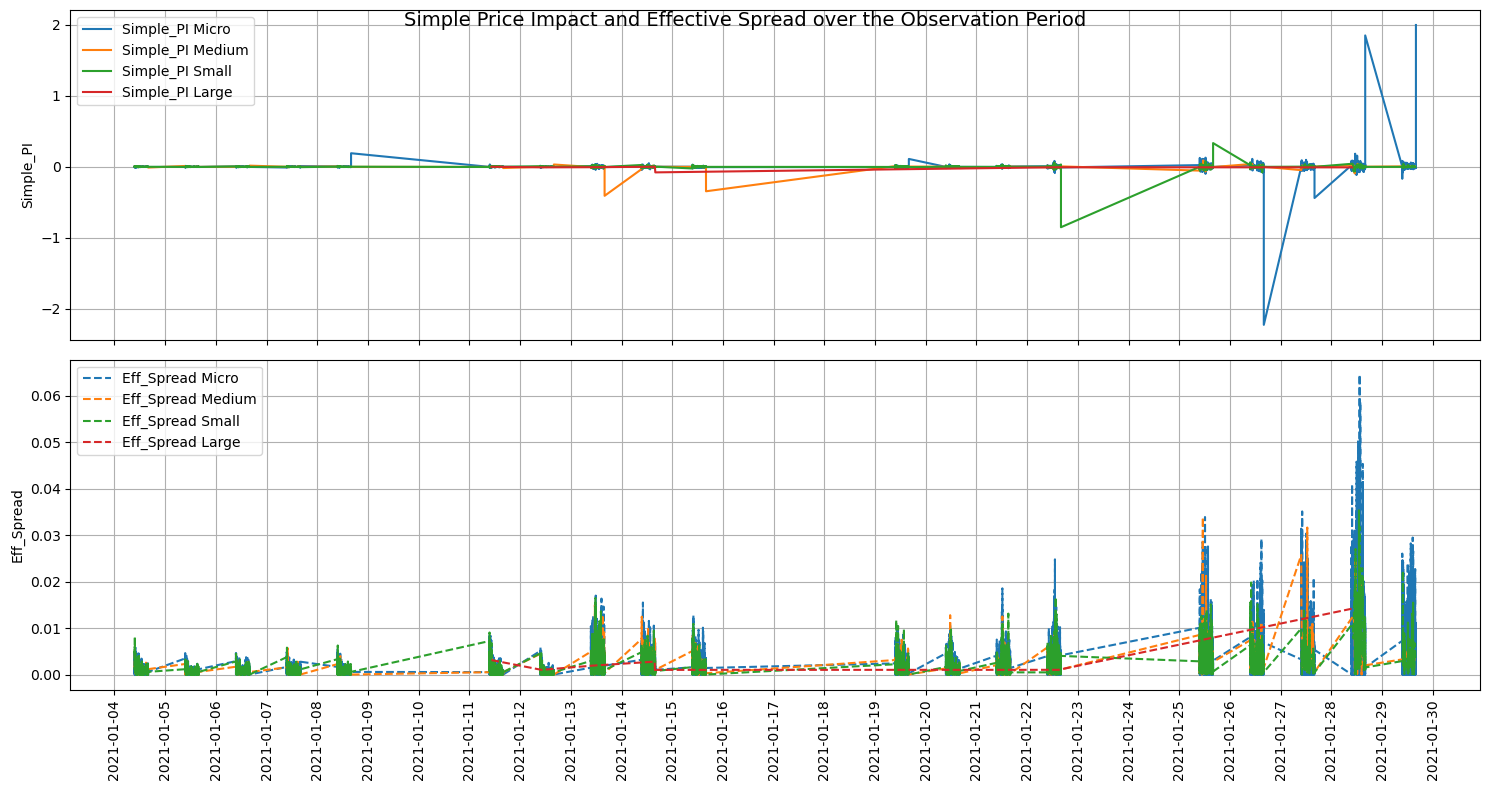

In [212]:
# Plotting

fig, (ax0, ax1) = plt.subplots(2, figsize = (15,8), sharex = True)

trade_size_l1 = trade_5_s['Trade_Size_L1'].unique()

for i, size in enumerate(trade_size_l1):
    subdata = trade_5_s[trade_5_s['Trade_Size_L1'] == size]
    ax0.plot(subdata.index, subdata['Simple_PI'], label = 'Simple_PI ' + size)
    ax1.plot(subdata.index, subdata['Eff_Spread'], linestyle = '--', label = 'Eff_Spread ' + size)

plt.xticks(rotation = 90)


# Ticks, Title, Labels
ax0.xaxis.set_major_locator(mdates.DayLocator())
ax0.legend()
ax0.set_ylabel('Simple_PI')
ax0.grid()

ax1.legend()
ax1.set_ylabel('Eff_Spread')
ax1.grid()

plt.tight_layout()
plt.suptitle('Simple Price Impact and Effective Spread over the Observation Period', fontsize = 14)
plt.show()

In [213]:
trade_5_s.loc[trade_5_s['Simple_PI'] == min(trade_5_s['Simple_PI'])]

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,...,Next_Mid_Quote,Mid_Quote_Return,Prev_Price,Price_Change,Price_Change_Abs,TickSB,Simple_PI,Eff_Spread,Realised_Spread,Price_Change/Unit_Vol
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-01-26 15:59:55,Trade,145.0,5.0,145.0,4.0,146.0,46.0,v,2021-01-26,-1.0,...,307.5,0.000344,145.16,-0.16,0.16,-1.0,-2.226804,0.006873,2.233677,-0.032


In [214]:
trade_5_s.describe()

,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,num_tick_direction,Mid_Quote,Prev_Mid_Quote,Next_Mid_Quote,Mid_Quote_Return,Prev_Price,Price_Change,Price_Change_Abs,TickSB,Simple_PI,Eff_Spread,Realised_Spread,Price_Change/Unit_Vol
count,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88688.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000,88689.000000
mean,78.945992,112.601258,78.677516,4.072980,79.229558,5.586651,0.001624,78.953537,78.949836,78.953323,0.000047,78.942294,0.003483,0.261829,-0.036419,0.000990,0.001854,0.000864,0.000154
std,100.976191,274.673687,100.520960,13.839007,101.455227,29.722791,0.913896,100.987381,100.984260,100.987528,0.006336,100.973075,1.204539,1.175743,0.993441,0.014308,0.002739,0.014309,0.413478
min,17.100000,1.000000,17.080000,1.000000,17.110000,1.000000,-1.000000,17.105000,0.000000,0.000000,-0.219458,0.000000,-76.840000,0.000000,-1.000000,-2.226804,0.000000,-1.998538,-36.190000
25%,18.890000,24.000000,18.876667,1.000000,18.912857,1.000000,-1.000000,18.895000,18.895000,18.895000,-0.000404,18.890000,-0.016000,0.002900,-1.000000,-0.000380,0.000420,-0.000286,-0.000200
50%,37.645000,86.000000,37.600000,2.000000,37.695000,2.000000,0.000000,37.645000,37.645000,37.645000,0.000000,37.645000,0.000000,0.020000,-1.000000,0.000143,0.000998,0.000552,0.000000
75%,74.700000,100.000000,74.420000,3.000000,74.890000,3.000000,1.000000,74.625000,74.610000,74.625000,0.000497,74.690000,0.020000,0.130000,1.000000,0.001559,0.002169,0.002092,0.000300
max,482.000000,25043.000000,480.360000,989.000000,482.500000,4106.000000,1.000000,481.430000,481.430000,481.430000,1.113402,482.000000,184.000000,184.000000,1.000000,2.000000,0.064502,2.233677,13.280000


## Regression and Robustness Check

In [215]:
trade_5_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88689 entries, 2021-01-04 09:30:00 to 2021-01-29 15:59:55
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Type                   56852 non-null  object 
 1   Price                  88689 non-null  float64
 2   Volume                 88689 non-null  float64
 3   Bid Price              88689 non-null  float64
 4   Bid Size               88689 non-null  float64
 5   Ask Price              88689 non-null  float64
 6   Ask Size               88689 non-null  float64
 7   Tick Dir.              48534 non-null  object 
 8   Date                   56852 non-null  object 
 9   num_tick_direction     88688 non-null  float64
 10  Exchange_Time_copy     56852 non-null  object 
 11  Trade_Size_L1          88689 non-null  object 
 12  Trade_Size_L2          88689 non-null  object 
 13  Mid_Quote              88689 non-null  float64
 14  Prev_Mid_Quote     

In [223]:
trade_5_s['Price_Change/Unit_Vol'] = trade_5_s['Price_Change']/trade_5_s['Volume']
trade_5_s['Price_Change/Unit_Vol_lag'] = trade_5_s['Price_Change/Unit_Vol'].shift(1).fillna(0)
display(trade_5_s)

,Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Tick Dir.,Date,num_tick_direction,...,Mid_Quote_Return,Prev_Price,Price_Change,Price_Change_Abs,TickSB,Simple_PI,Eff_Spread,Realised_Spread,Price_Change/Unit_Vol,Price_Change/Unit_Vol_lag
Date-Time,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:00,Trade,19.060000,100.0,19.000000,22.000000,19.060,1.0,^,2021-01-04,1.000000,...,0.000000,0.00,0.000000,0.000000,1.0,0.004204,0.003153,-0.001051,0.000000,0.000000
2021-01-04 09:30:05,Trade,19.100000,85.0,19.040000,2.000000,19.100,1.0,^,2021-01-04,1.000000,...,0.002102,19.06,0.040000,0.040000,1.0,-0.001311,0.003146,0.004457,0.000471,0.000000
2021-01-04 09:30:10,None,19.080000,92.5,19.020000,12.500000,19.095,1.0,None,None,1.000000,...,-0.000655,19.10,-0.020000,0.020000,1.0,-0.001312,0.002361,0.003673,-0.000216,0.000471
2021-01-04 09:30:15,Trade,19.060000,100.0,19.000000,23.000000,19.090,1.0,^,2021-01-04,1.000000,...,-0.000656,19.08,-0.020000,0.020000,1.0,-0.000350,0.001575,0.001925,-0.000200,-0.000216
2021-01-04 09:30:20,None,19.056667,100.0,19.003333,15.666667,19.080,1.0,None,None,0.333333,...,-0.000175,19.06,-0.003333,0.003333,1.0,-0.000350,0.001575,0.001926,-0.000033,-0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:59:35,Trade,328.010000,17.0,328.000000,50.000000,328.470,1.0,v,2021-01-29,-1.000000,...,-0.000122,328.39,-0.380000,0.380000,-1.0,-0.002864,0.001371,0.004235,-0.022353,-0.610000
2021-01-29 15:59:40,Trade,328.750000,70.0,328.470000,7.000000,328.940,1.0,v,2021-01-29,-1.000000,...,0.001432,328.01,0.740000,0.740000,1.0,-0.001278,0.000274,0.001552,0.010571,-0.022353
2021-01-29 15:59:45,Trade,328.490000,1.0,328.490000,6.000000,328.500,2.0,^,2021-01-29,1.000000,...,-0.000639,328.75,-0.260000,0.260000,-1.0,0.000883,0.000030,-0.000852,-0.260000,0.010571


In [225]:
# One-hot Encoding

X_1 = trade_5_s[['Simple_PI', 'Price_Change/Unit_Vol_lag']]
X_2 = pd.get_dummies(trade_5_s['Trade_Size_L1'])
y = trade_5_s['Price_Change/Unit_Vol']

X = pd.concat([X_2, X_1], axis = 1)

# Reindex the columns so Micro will be the 1st column: Mic - S - M - L
X = X.reindex(columns = ['Micro', 'Small', 'Medium', 'Large', 'Simple_PI', 'Price_Change/Unit_Vol_lag'])
display(X)

print(f'X shape: {X.shape}, X columns = {X.columns}')
print(f'y shape: {y.shape}')

,Micro,Small,Medium,Large,Simple_PI,Price_Change/Unit_Vol_lag
Date-Time,,,,,,
2021-01-04 09:30:00,1,0,0,0,0.004204,0.000000
2021-01-04 09:30:05,1,0,0,0,-0.001311,0.000000
2021-01-04 09:30:10,1,0,0,0,-0.001312,0.000471
2021-01-04 09:30:15,1,0,0,0,-0.000350,-0.000216
2021-01-04 09:30:20,1,0,0,0,-0.000350,-0.000200
...,...,...,...,...,...,...
2021-01-29 15:59:35,1,0,0,0,-0.002864,-0.610000
2021-01-29 15:59:40,1,0,0,0,-0.001278,-0.022353
2021-01-29 15:59:45,1,0,0,0,0.000883,0.010571


X shape: (88689, 6), X columns = Index(['Micro', 'Small', 'Medium', 'Large', 'Simple_PI',
       'Price_Change/Unit_Vol_lag'],
      dtype='object')
y shape: (88689,)


,Micro,Small,Medium,Large,Simple_PI,Price_Change/Unit_Vol_lag,Price_Change/Unit_Vol
Date-Time,,,,,,,
2021-01-04 09:30:00,1,0,0,0,0.004204,0.000000,0.000000
2021-01-04 09:30:05,1,0,0,0,-0.001311,0.000000,0.000471
2021-01-04 09:30:10,1,0,0,0,-0.001312,0.000471,-0.000216
2021-01-04 09:30:15,1,0,0,0,-0.000350,-0.000216,-0.000200
2021-01-04 09:30:20,1,0,0,0,-0.000350,-0.000200,-0.000033
...,...,...,...,...,...,...,...
2021-01-29 15:59:35,1,0,0,0,-0.002864,-0.610000,-0.022353
2021-01-29 15:59:40,1,0,0,0,-0.001278,-0.022353,0.010571
2021-01-29 15:59:45,1,0,0,0,0.000883,0.010571,-0.260000


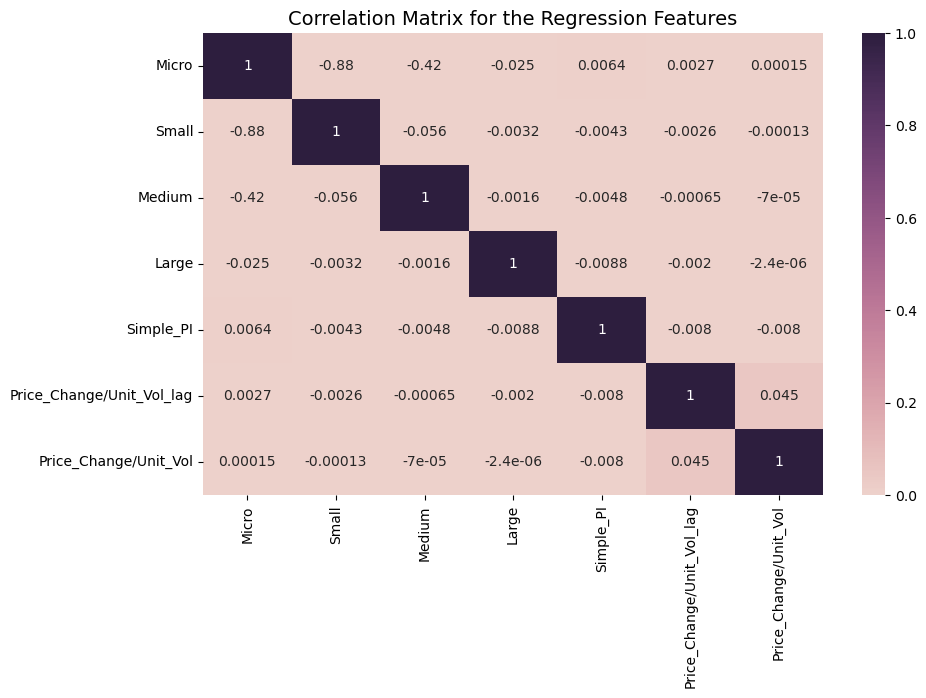

In [226]:
# Correlation Matrix

combined = pd.concat([X, y], axis = 1)
display(combined)
combined_corr = combined.corr()
plt.figure(figsize = (10,6))
sns.heatmap(combined_corr, vmin = 0., vmax = 1., cmap = sns.cubehelix_palette(as_cmap = True), annot = True)
plt.title('Correlation Matrix for the Regression Features', fontsize = 14)
plt.show()


In [228]:
# Linear Regression

X = sm.add_constant(X)
linreg = sm.OLS(y, X)
results = linreg.fit()
print(results.summary())
print(results.t_test)

                              OLS Regression Results                             
Dep. Variable:     Price_Change/Unit_Vol   R-squared:                       0.002
Model:                               OLS   Adj. R-squared:                  0.002
Method:                    Least Squares   F-statistic:                     36.93
Date:                   Tue, 28 Mar 2023   Prob (F-statistic):           5.92e-38
Time:                           00:44:42   Log-Likelihood:                -47426.
No. Observations:                  88689   AIC:                         9.486e+04
Df Residuals:                      88683   BIC:                         9.492e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

## Spearman Correlation Test

## p-value for each # of trade, size vs cum price change

# Not for Final Report

## Resample and Intervals 

In [ ]:
    # Add Subtotals
    
#     piv_cumprice = pd.concat([y.append(y.sum().rename((x, 'Total')))for x, y in piv_cumprice.groupby(level = 0)]).append(piv_cumprice.sum().rename(('Grand', 'Total')))

In [ ]:
# # Inner Join based on Trade L1 -- different size different list

# # Small
# index0_s = small_var_rat_1.index.names[0]
# index1_s = small_var_rat_1.index.names[1]
    # Add Subtotals
    
#     piv_cumprice = pd.concat([y.append(y.sum().rename((x, 'Total')))for x, y in piv_cumprice.groupby(level = 0)]).append(piv_cumprice.sum().rename(('Grand', 'Total')))
# s_var_rat_1_5 = pd.merge(small_var_rat_1, small_var_rat_5, on = [index0_s, index1_s], how = 'inner')
# # display(s_var_rat_1_5)

# # Medium
# index0_m = med_var_rat_1.index.names[0]
# index1_m = med_var_rat_5.index.names[1]

# m_var_rat_1_5 = pd.merge(med_var_rat_1, med_var_rat_5, on = [index0_m, index1_m], how = 'inner')
# # display(m_var_rat_1_5)


# # Rename Columns for Small
# s_var_rat_1_5 = s_var_rat_1_5.rename(columns = {'STD of MQR_x':'STD of MQR_1', 'Variance_x':'Var_of_MQR_1',
#                                                'STD of MQR_y':'STD of MQR_5', 'Variance_y':'Var_of_MQR_5'
#                                                })

# # Rename Columns for Medium
# m_var_rat_1_5 = m_var_rat_1_5.rename(columns = {'STD of MQR_x':'STD of MQR_1', 'Variance_x':'Var_of_MQR_1',
#                                                'STD of MQR_y':'STD of MQR_5', 'Variance_y':'Var_of_MQR_5'
#                                                })

# # Index for pivot Small

# list_s = list(s_var_rat_1_5['key_0'])
# index_date_s = []
# for i in list_s:
#     date_a = i[0]
#     index_date_s.append(date_a)


# # Index for pivot Medium

# list_m = list(m_var_rat_1_5['key_0'])
# index_date_m = []
# for i in list_m:
#     date_a = i[0]
#     index_date_m.append(date_a)
    
# # Add Variance Ratio Calculation
# s_var_rat_1_5['Var_Rat'] = np.abs((s_var_rat_1_5['Var_of_MQR_5']/(5 * s_var_rat_1_5['Var_of_MQR_1'])) - 1)
# m_var_rat_1_5['Var_Rat'] = np.abs((m_var_rat_1_5['Var_of_MQR_5']/(5 * m_var_rat_1_5['Var_of_MQR_1'])) - 1)

# display(s_var_rat_1_5)
# display(m_var_rat_1_5)

In [ ]:
# trade_1_min_micro = trade_1_min[trade_1_min['Trade_Size_L1'] == 'Small']
# trade_5_min_micro = trade_5_min[trade_5_min['Trade_Size_L1'] == 'Small']
# trade_1_min_small = trade_1_min[trade_1_min['Trade_Size_L1'] == 'Small']
# trade_5_min_small = trade_5_min[trade_5_min['Trade_Size_L1'] == 'Small']
# trade_1_min_med = trade_1_min[trade_1_min['Trade_Size_L1'] == 'Medium']
# trade_5_min_med = trade_5_min[trade_5_min['Trade_Size_L1'] == 'Medium']
# # trade_1_min_large = trade_1_min[trade_1_min['Trade_Size_L1'] == 'Large']
# # trade_5_min_large = trade_5_min[trade_5_min['Trade_Size_L1'] == 'Large']


# small_var_rat_1 = piv_varrat(trade_1_min_small)
# small_var_rat_5 = piv_varrat(trade_5_min_small)

# med_var_rat_1 = piv_varrat(trade_1_min_med)
# med_var_rat_5 = piv_varrat(trade_5_min_med)

# # Trade_5_min

# # large_var_rat_1 = piv_varrat(trade_1_min_large)
# # large_var_rat_5 = piv_varrat(trade_5_min_large)

# display(small_var_rat_1)
# display(small_var_rat_1.index.names[1])

In [ ]:
def resample_last(df, interval):
    '''
    This will not be used in the final analysis -- only for gauging the impact of different
    resample aggregation functions.
    default interpolation: linear
    df input = df name, e.g. trade
    interval input = as per requirement, in string, e.g. 'T', '5S', etc
    '''
    df_res = df.resample(interval).last().interpolate(method = 'linear')
    
    nan_price = df_res[df_res['Price'].isna()].index
    print('Original focus length before resampled:', len(df))
    print('Length after resampled:', len(df_res))
    print(f'Total Price NA: {len(nan_price)}')
    if len(nan_price) == 0:
        print('OK')
    display(df_res.describe())
    
    return df_res, interval

In [ ]:
def resample_mean(df, interval):
    '''
    This will not be used in the final analysis -- only for gauging the impact of different
    resample aggregation functions.
    default interpolation: linear
    df input = df name, e.g. trade
    interval input = as per requirement, in string, e.g. 'T', '5S', etc
    '''
    df_res = df.resample(interval).mean().interpolate(method = 'linear')
    
    nan_price = df_res[df_res['Price'].isna()].index
    print('Original focus length before resampled:', len(df))
    print('Length after resampled:', len(df_res))
    print(f'Total Price NA: {len(nan_price)}')
    if len(nan_price) == 0:
        print('OK')
    display(df_res.describe())
    
    return df_res, interval

In [ ]:
# Compare Resample Intervals and Technique
trade_min_last, int1 = resample_last(trade, 'T')
trade_h_last, int2 = resample_last(trade, 'H')
trade_min_mean, int3 = resample_mean(trade, 'T')
trade_h_mean, int4 = resample_mean(trade, 'H')

In [ ]:
#     fig, ax = plt.subplots(figsize = (10,4))

#     ax = sns.lineplot(x = df.index, y = 'Mid_Quote_Return', data = df, hue = 'Trade_Size_L1')

#     ax.set_xlabel('Date-Time')
#     ax.set_ylabel('Mid_Quote_Return')
#     ax.xaxis.set_major_locator(mdates.DayLocator())

#     ax.legend()

#     plt.title(f'Mid_Quote_Return of  Resampled Data , S-M-L Trade Sizes')
#     plt.grid()
#     plt.xticks(rotation = 90)
#     plt.show()

#     display(df['Trade_Size_L1'].value_counts())
#     display(df['Trade_Size_L2'].value_counts())

In [ ]:
# # Take the minute _ last

# # Create Pivot Table

# dates = trade_min_last.index.date
# var_rat = pd.pivot_table(trade_min_last, index = [dates,'Trade_Size_L1'],
#                              values = ['Mid_Quote_Return'], 
#                               aggfunc = sum, fill_value = 0, margins = False)

# display(trade_min_last.loc[trade_min_last['Trade_Size_L1'] == 'Large'])
# var_rat

# # Looks like the var_rat data calc has issue for std... try in csv

In [ ]:
# # Test diff aggregate function

# trade_min_test = trade.resample('T').agg({'Price' : 'mean', 'Volume' : 'last'})
# display(trade_min_test)
# display(trade_min_test.describe())

In [ ]:
# Fill the NaN value

# trade_min.loc[-1, 'Mid_Quote_Return'] = 0 --> doesn't work, add last row index -1
# trade_min.info()
# trade_min.drop(-1, inplace = True) --> must drop first
# trade_min['Mid_Quote_Return'].iloc[-1] --> works alone, but has to be paired with column index
# trade_min.loc[trade_min['Mid_Quote_Return'].iloc[-1],'Mid_Quote_Return']  = 0 --> doesn't work, only int

In [ ]:
# Sorting L0 cat custom

# import pandas as pd

# # create a sample DataFrame
# df = pd.DataFrame({'A': ['foo', 'foo', 'bar', 'bar', 'foo', 'foo'],
#                    'B': ['one', 'one', 'one', 'two', 'two', 'one'],
#                    'C': [1, 2, 3, 4, 5, 6],
#                    'D': [7, 8, 9, 10, 11, 12]})

# # create pivot table
# pivot_table = pd.pivot_table(df, values=['C', 'D'], index=['A', 'B'], aggfunc={'C': 'sum', 'D': 'mean'})

# # define custom order for first level index
# custom_order = ['bar', 'foo']

# # create a Categorical data type with custom order
# cat_dtype = pd.CategoricalDtype(categories=custom_order, ordered=True)

# # convert first level index to Categorical data type
# pivot_table.index = pivot_table.index.set_levels(pivot_table.index.levels[0].astype(cat_dtype), level=0)

# # sort pivot table by first level index
# pivot_table = pivot_table.sort_values(by=pivot_table.index.levels[0].name)

# print(pivot_table)


In [ ]:
# Apply function how

# df = pd.DataFrame({'Name': ['John', 'Sammy', 'Stephan', 'Joe', 'Emily', 'Tom'],
#                    'Gender': ['Male', 'Female', 'Male',
#                               'Female', 'Female', 'Male'],
#                    'Age': [45, 6, 4, 36, 12, 43]})
# print("Dataset")
# print(df)
# print("-"*40)
  
# # categorizing in age groups
# def age_bucket(age):
#     if age <= 18:
#         return "<18"
#     else:
#         return ">18"
  
# df['Age Group'] = df['Age'].apply(age_bucket)
  
# # calculating gender percentage
# gender = pd.DataFrame(df.Gender.value_counts(normalize=True)*100).reset_index()
# gender.columns = ['Gender', '%Gender']
# df = pd.merge(left=df, right=gender, how='inner', on=['Gender'])
  
# # creating pivot table
# table = pd.pivot_table(df, index=['Gender', '%Gender', 'Age Group'], 
#                        values=['Name'], aggfunc={'Name': 'count',})
  
# # display table
# print("Table")
# print(table)

In [ ]:
# Aggregate Function

# mean(): calculates the mean of each group
# sum(): calculates the sum of each group
# max(): returns the maximum value of each group
# min(): returns the minimum value of each group
# first(): returns the first value of each group
# last(): returns the last value of each group
# count(): returns the number of non-NA/null values in each group
# median(): returns the median of each group
# std(): calculates the standard deviation of each group
# var(): calculates the variance of each group

In [ ]:
#     for i, size in enumerate(trade_size_l1):
#         subdata = trade[trade['Trade_Size_L1'] == size]
#         ax0.plot(subdata.index, subdata['Mid_Quote_Return'], label = 'Mid-Quote Return' + size)
#         ax1.plot(subdata.index, subdata['Price_Change'], label = 'Price Change' + size, ls = '--')


In [ ]:
## Plot and Bins

In [ ]:
# # fig, ax = plt.subplots(figsize = (10,4))

# sns.lineplot(x = trade.index, y = 'Mid_Quote_Return', data = trade) #, hue = 'Trade_Size_L1' --> always slow idk why

# # ax.set_xlabel('Date-Time')
# # ax.set_ylabel('Mid_Quote_Return')
# # ax.xaxis.set_major_locator(mdates.DayLocator())

# # ax.legend()

# # plt.title(f'Mid_Quote_Return, S-M-L Trade Sizes')
# # plt.grid()
# # plt.xticks(rotation = 90)
# plt.show()

# display(trade['Trade_Size_L1'].value_counts())
# display(trade['Trade_Size_L2'].value_counts())
# trade_size_l1 = trade['Trade_Size_L1'].unique()

# fig, ax = plt.subplots(figsize = (12,6))

# ax0 = fig.add_subplot()
# plt.xticks(rotation = 90)

# ax1 = ax0.twinx()

# for i, size in enumerate(trade_size_l1):
#     subdata = trade[trade['Trade_Size_L1'] == size]
#     ax0.plot(subdata.index, subdata['Mid_Quote_Return'], label = 'Mid-Quote Return' + size)
#     ax1.plot(subdata.index, subdata['Price_Change'], label = 'Price Change' + size, ls = '--')
    
# ax0.grid()

# # Ticks, Title, Labels
# ax0.xaxis.set_major_locator(mdates.DayLocator())
# ax0.set_ylabel('Mid-Quote Return')
# ax1.set_ylabel('Price Change')
# fig.legend()
# fig.suptitle('Mid-Quote Return and Price Change by Size (not resampled)', fontsize = 14)

# plt.show()


In [ ]:
# Plotting

# interval = [int1, int2, int3, int4]
# aggr = ['last', 'last', 'mean', 'mean']
# for i in range(len(result)):
#     plot_(result[i], interval[i], aggr[i])



In [ ]:
min_sample = 19 * 6.5 * 60 # --> 19 days of sample, 6.5 hr trading window, 60 min
print(min_sample)
min_5sample = 19 * 6.5 * 12 # --> 5min interval
print(min_5sample)